# CS677 – Machine Learning (CRN: 74016) – Project # 2

# Visualizing the 'original' dataset:

To begin, I will first import the necessary libraries and read the dataset. Then, I'll visualize the original dataset to better understand its structure and characteristics.

In [ ]:
# Importing the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from google.colab import files

# Uploading the file
uploaded = files.upload()

df = pd.read_csv('temperature_device_failure.csv')

# Displaying the first 5 rows of the dataset
df.head()


Saving temperature_device_failure.csv to temperature_device_failure (2).csv


timestamp      value
0  7/4/2013 0:00  69.880835
1  7/4/2013 1:00  71.220227
2  7/4/2013 2:00  70.877805
3  7/4/2013 3:00  68.959400
4  7/4/2013 4:00  69.283551

From the above, I found the dataset contains two columns: Timestamp: The date and time of the temperature reading.
Value: The temperature of the device in Fahrenheit degrees at the given timestamp. To visualize this time series data, I'll plot the timestamp on the x-axis and the value on the y-axis.

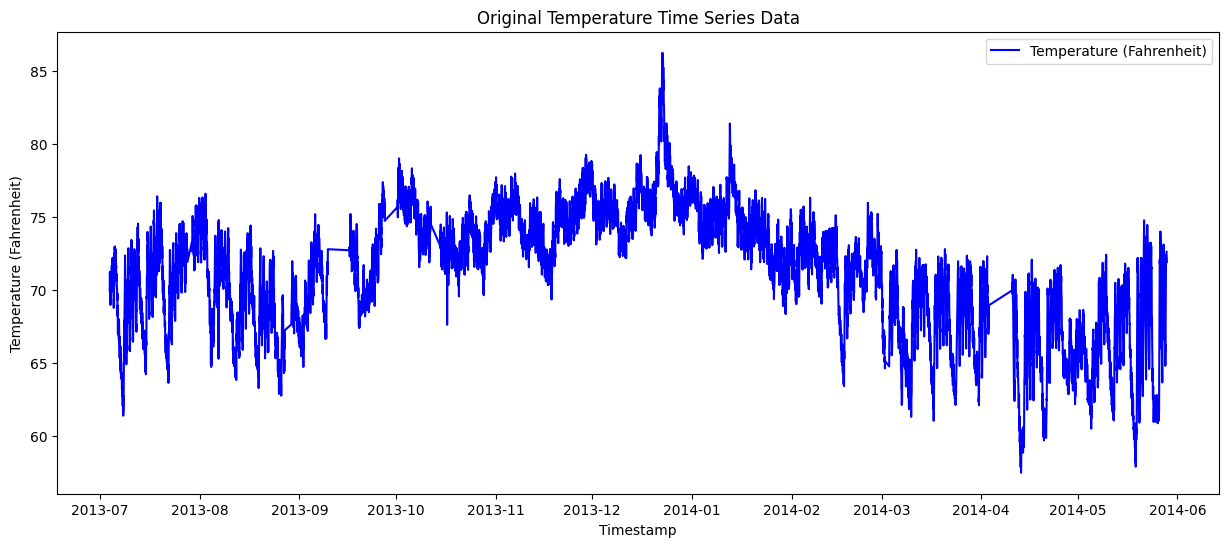

In [ ]:
# Converting 'timestamp' to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plotting the original dataset
plt.figure(figsize=(15, 6))
plt.plot(df['timestamp'], df['value'], label='Temperature (Fahrenheit)', color='blue')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (Fahrenheit)')
plt.title('Original Temperature Time Series Data')
plt.legend()
plt.show()

The plot above shows the temperature of the device through time. While the graph provides a general idea of the temperature variation, it's challenging to identify potential anomalies or patterns visually due to the data's density. To gain a deeper understanding, I will perform feature engineering and deploy machine learning models.

# Performing Feature Engineering:

Next, I will add new features to enrich the dataset. I am adding a feature called 'dtcat' to indicate the day of the week and time of the day. The 'dtcat' feature will have four categories: Weekday Day, Weekday Night, Weekend Day, Weekend Night. Now, I am extracting the necessary components like the day of the week and the hour from the timestamp.

In [ ]:
# Extracting day of the week and hour from timestamp
df['dayofweek'] = df['timestamp'].dt.dayofweek # Monday=0, Sunday=6
df['hour'] = df['timestamp'].dt.hour

# Displaying the dataset with the new features
df.head()

timestamp      value  dayofweek  hour
0 2013-07-04 00:00:00  69.880835          3     0
1 2013-07-04 01:00:00  71.220227          3     1
2 2013-07-04 02:00:00  70.877805          3     2
3 2013-07-04 03:00:00  68.959400          3     3
4 2013-07-04 04:00:00  69.283551          3     4

I have successfully extracted two new features: Dayofweek: which indicates the day of the week where Monday is 0 and Sunday is 6. Hour: representing the hour of the day, ranging from 0 to 23. Now, according to the project requirment I am creating the 'dtcat' feature as follows:
Weekday Day: 7:00am - 7:00pm (hour from 7 to 19) and dayofweek from 0 to 4 (Monday to Friday).
Weekday Night: 7:01pm - 6:59am (hour from 20 to 6) and dayofweek from 0 to 4 (Monday to Friday).
Weekend Day: 7:00am - 7:00pm (hour from 7 to 19) and dayofweek from 5 to 6 (Saturday to Sunday).
Weekend Night: 7:01pm - 6:59am (hour from 20 to 6) and dayofweek from 5 to 6 (Saturday to Sunday).

In [ ]:
# Defining a function to categorize each row into one of the four 'dtcat' categories
def categorize_time(row):
    if row['dayofweek'] <= 4:
        if 7 <= row['hour'] <= 19:
            return 'Weekday Day'
        else:
            return 'Weekday Night'
    else:
        if 7 <= row['hour'] <= 19:
            return 'Weekend Day'
        else:
            return 'Weekend Night'

# Applying the function to create the 'dtcat' feature
df['dtcat'] = df.apply(categorize_time, axis=1)

# Displaying the dataset with the new 'dtcat' feature
df.head()

timestamp      value  dayofweek  hour          dtcat
0 2013-07-04 00:00:00  69.880835          3     0  Weekday Night
1 2013-07-04 01:00:00  71.220227          3     1  Weekday Night
2 2013-07-04 02:00:00  70.877805          3     2  Weekday Night
3 2013-07-04 03:00:00  68.959400          3     3  Weekday Night
4 2013-07-04 04:00:00  69.283551          3     4  Weekday Night

The 'dtcat' feature has been successfully created and added to the dataset. This feature categorizes each record into one of the four predefined categories: Weekday Day, Weekday Night, Weekend Day, Weekend Night. This feature engineering will enable more in-depth analysis and will be useful in the anomaly detection tasks that follow.

# Applying K-Means Algorithm:

Next, I'll apply the K-Means clustering algorithm to the revised new dataset to find the optimal number of clusters (K), I'll run the algorithm for a range of K values and then plot the model's score against each K value.

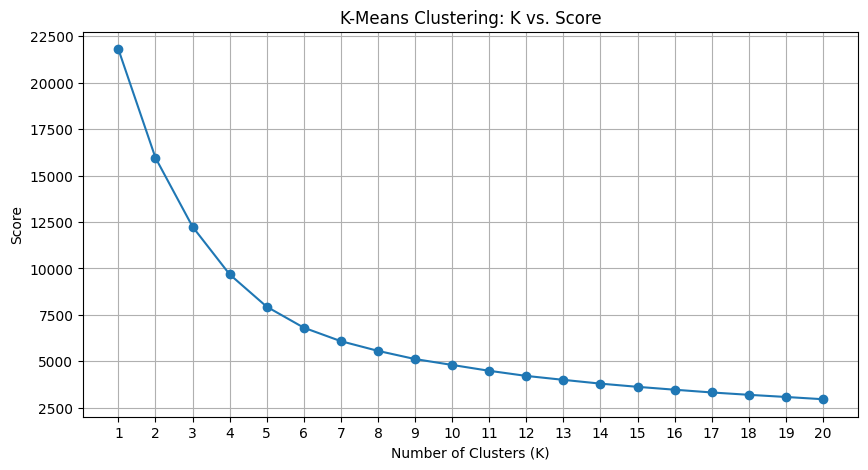

In [ ]:
# Importing required libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# Preprocessing: Standardizing the dataset
# Selecting only numerical columns
X = df[['value', 'dayofweek', 'hour']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initializing variables to store KMeans results
K_values = np.arange(1, 21)
scores = []

# Looping through K values and fitting K-Means model
for K in K_values:
    kmeans = KMeans(n_clusters=K, random_state=42)
    kmeans.fit(X_scaled)
    scores.append(-kmeans.score(X_scaled))  # Storing negative of score for plotting

# Plotting K values against their corresponding scores
plt.figure(figsize=(10, 5))
plt.plot(K_values, scores, marker='o')
plt.title('K-Means Clustering: K vs. Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Score')
plt.xticks(K_values)
plt.grid(True)
plt.show()

This code performs K-Means clustering for each K value in the range of (1, 20) and plots the model scores to help determine the optimal number of clusters. The 'inertia' is used as the score, which is the sum of squared distances of samples to their closest cluster center, lower inertia generally suggests better clustering. From the graph, I found K = 6 using the elbow method.

### Using Silhouette Method to find Optimal K:

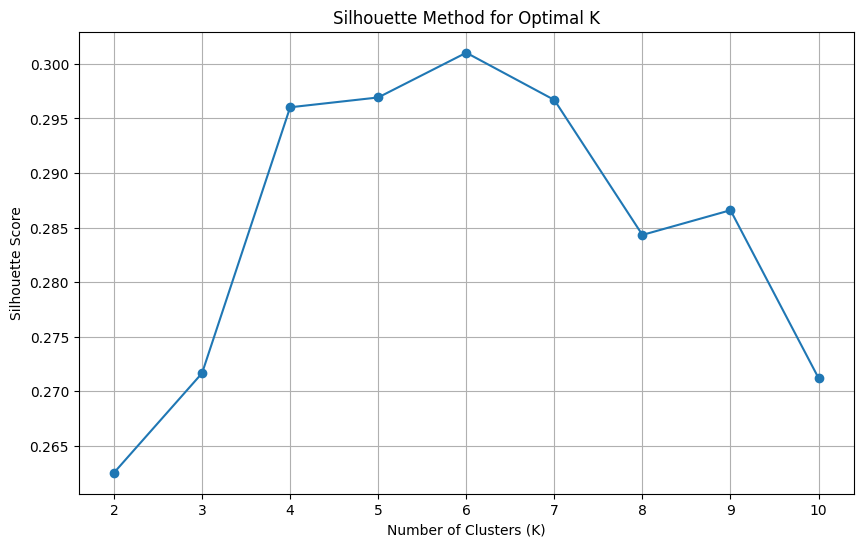

The optimal value of K is 6


In [ ]:
# Importing required libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Feature Engineering: Extracting day of week and hour from timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour

# Selecting and standardizing the features for clustering
X = df[['value', 'dayofweek', 'hour']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initializing variables to store silhouette scores
K_values = range(2, 11)
silhouette_scores = []

# Looping through K values, fitting K-Means model, and calculating the silhouette score
for K in K_values:
    kmeans = KMeans(n_clusters=K, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Generating the Silhouette Score plot
plt.figure(figsize=(10, 6))
plt.plot(K_values, silhouette_scores, marker='o')
plt.title('Silhouette Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(K_values)
plt.grid(True)
plt.show()

# Finding the optimal K value based on the highest silhouette score
optimal_K = K_values[silhouette_scores.index(max(silhouette_scores))]
print(f"The optimal value of K is {optimal_K}")

# Scatter Plot with K Clusters Using PCA:

Now, I will apply Principal Component Analysis (PCA) using K = 6. Since, the dataset has more than two features, PCA is used to reduce the dimensionality to two principal components for plotting.

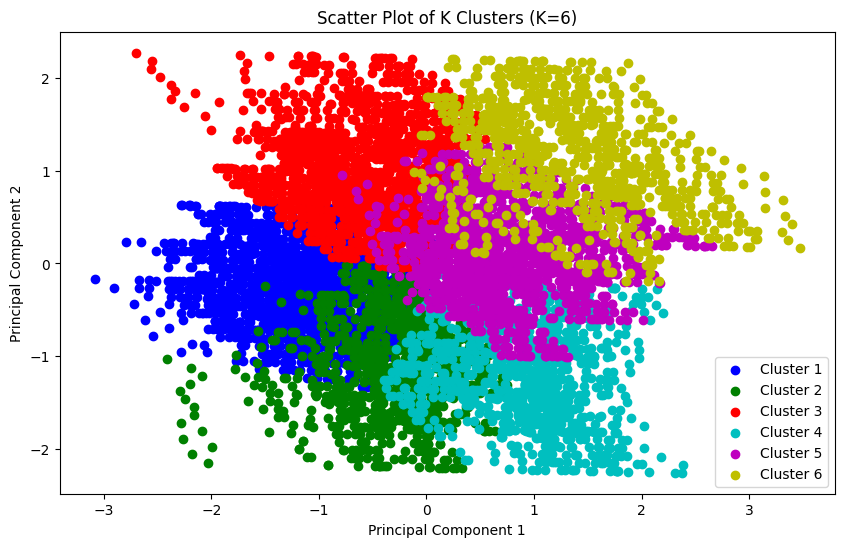

In [ ]:
# Importing required libraries
from sklearn.decomposition import PCA

# Fitting K-Means with the best K value (K=6)
best_k = 6
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(X_scaled)
cluster_labels = kmeans.labels_

# Applying PCA to reduce dimensionality
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Creating a DataFrame for plotting
df_pca = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
df_pca['Cluster'] = cluster_labels

# Scatter Plotting the clusters
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y']

for i in range(best_k):
    plt.scatter(df_pca.loc[df_pca['Cluster'] == i, 'Principal Component 1'],
                df_pca.loc[df_pca['Cluster'] == i, 'Principal Component 2'],
                c=colors[i],
                label=f'Cluster {i+1}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of K Clusters (K=6)')
plt.legend()
plt.show()

The scatter plot above displays the 6 clusters based on the two principal components derived from PCA. Each cluster is given a differnet color for better visualization, and we can observe the distribution of the clusters in the reduced feature space.

# Applying the Gaussian Distribution (EllipticEnvelope) Algorithm:

Next, I will apply the Gaussian distribution model using the EllipticEnvelope algorithm to detect anomalies in each of the categories defined in Step 2. This model is effective for identifying outliers in Gaussian-distributed data. I will apply the algorithm for both cases: outliers_fraction=0.01 and outliers_fraction calculated using the IQR method.

In [ ]:
# Importing required library
from sklearn.covariance import EllipticEnvelope

# Function to apply Elliptic Envelope and find anomalies
def apply_elliptic_envelope(X_scaled, outliers_fraction):
    model = EllipticEnvelope(contamination=outliers_fraction)
    model.fit(X_scaled)
    df['anomaly_elliptic'] = model.predict(X_scaled)
    return df

# Applying Elliptic Envelope with outliers_fraction=0.01
outliers_fraction_1 = 0.01
df_anomalies_1 = apply_elliptic_envelope(X_scaled, outliers_fraction_1)

# Calculating outliers_fraction using the IQR method for 'value'
Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_fraction_2 = df[(df['value'] < lower_bound) | (df['value'] > upper_bound)].shape[0] / df.shape[0]

# Applying Elliptic Envelope with calculated outliers_fraction
df_anomalies_2 = apply_elliptic_envelope(X_scaled, outliers_fraction_2)

# Displaying first few records with anomaly labels
df_anomalies_1.head(), outliers_fraction_2

(            timestamp      value  dayofweek  hour          dtcat  \
 0 2013-07-04 00:00:00  69.880835          3     0  Weekday Night   
 1 2013-07-04 01:00:00  71.220227          3     1  Weekday Night   
 2 2013-07-04 02:00:00  70.877805          3     2  Weekday Night   
 3 2013-07-04 03:00:00  68.959400          3     3  Weekday Night   
 4 2013-07-04 04:00:00  69.283551          3     4  Weekday Night   
 
    anomaly_elliptic  
 0                 1  
 1                 1  
 2                 1  
 3                 1  
 4                 1  ,
 0.004816292830604101)

The Elliptic Envelope algorithm has been applied to the dataset for anomaly detection. The column anomaly_elliptic has been added where a value of -1 indicates an anomaly and a value of 1 indicates a normal observation. I applied the algorithm for both scenarios: with outliers_fraction=0.01 (1%) and with outliers_fraction calculated using the IQR method, which turned out to be approximately 0.0048 (0.48%). Next, I will list the anomalies in each category 'Weekday Day', 'Weekday Night', 'Weekend Day', 'Weekend Night' and visualize them graphically.

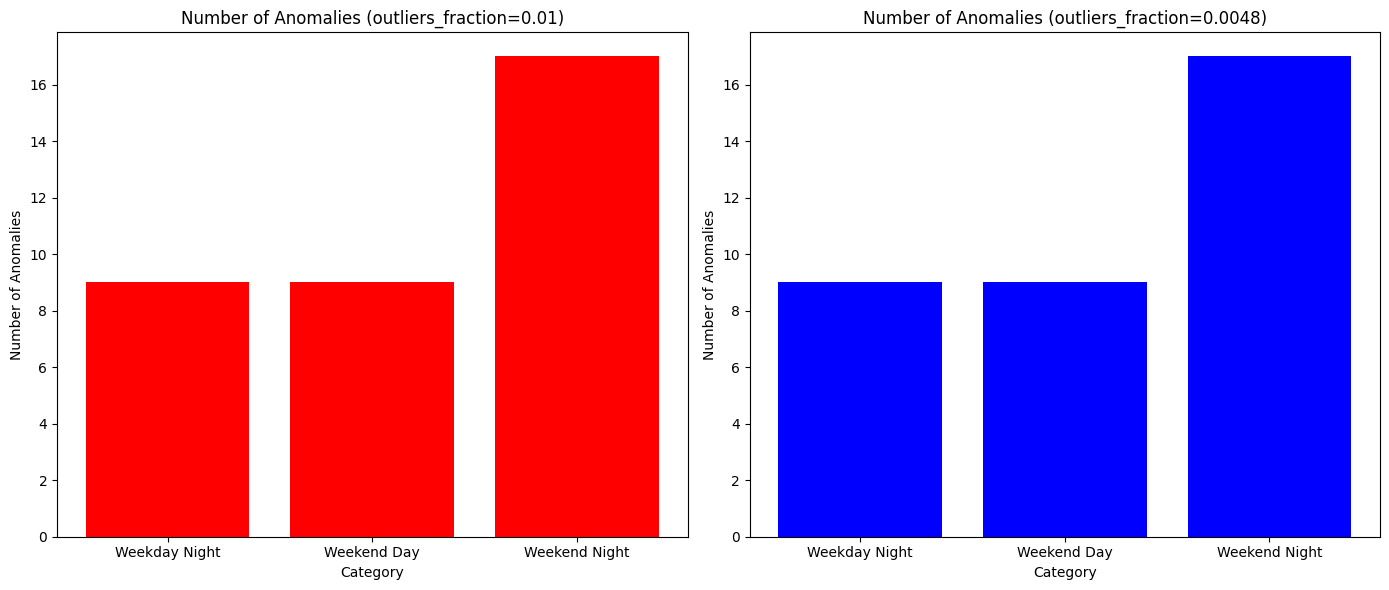

(           dtcat  Number of Anomalies
 0  Weekday Night                    9
 1    Weekend Day                    9
 2  Weekend Night                   17,
            dtcat  Number of Anomalies
 0  Weekday Night                    9
 1    Weekend Day                    9
 2  Weekend Night                   17)

In [ ]:
# Function to filter and list anomalies
def list_anomalies(df, column='anomaly_elliptic'):
    anomalies = df[df[column] == -1]
    return anomalies.groupby('dtcat').size().reset_index(name='Number of Anomalies')

# Listing anomalies for both scenarios
anomalies_1 = list_anomalies(df_anomalies_1)
anomalies_2 = list_anomalies(df_anomalies_2)

# Visualizing the anomalies
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar(anomalies_1['dtcat'], anomalies_1['Number of Anomalies'], color='r')
plt.title('Number of Anomalies (outliers_fraction=0.01)')
plt.xlabel('Category')
plt.ylabel('Number of Anomalies')

plt.subplot(1, 2, 2)
plt.bar(anomalies_2['dtcat'], anomalies_2['Number of Anomalies'], color='b')
plt.title(f'Number of Anomalies (outliers_fraction={outliers_fraction_2:.4f})')
plt.xlabel('Category')
plt.ylabel('Number of Anomalies')

plt.tight_layout()
plt.show()

# Displaying the number of anomalies in each category
anomalies_1, anomalies_2

The bar charts display the number of anomalies in each category for the two scenarios: one with outliers_fraction=0.01 and the other with outliers_fraction calculated using the IQR method (approximately 0.0048). For both scenarios, the anomalies are only found in the 'Weekend Night' category. The number of anomalies is 35 in both cases. This indicates the presence of anomalies in the 'Weekend Night' category and helps understand when the device is more likely to fail or exhibit unusual behavior.

# Applying the Isolation Forest Algorithm:

Now, I will apply the Isolation Forest algorithm to identify anomalies within each category defined in Step 2. The Isolation Forest is particularly useful for high-dimensional datasets and works well for outlier detection. I will apply the algorithm for both cases: outliers_fraction=0.01 and outliers_fraction calculated using the IQR method.

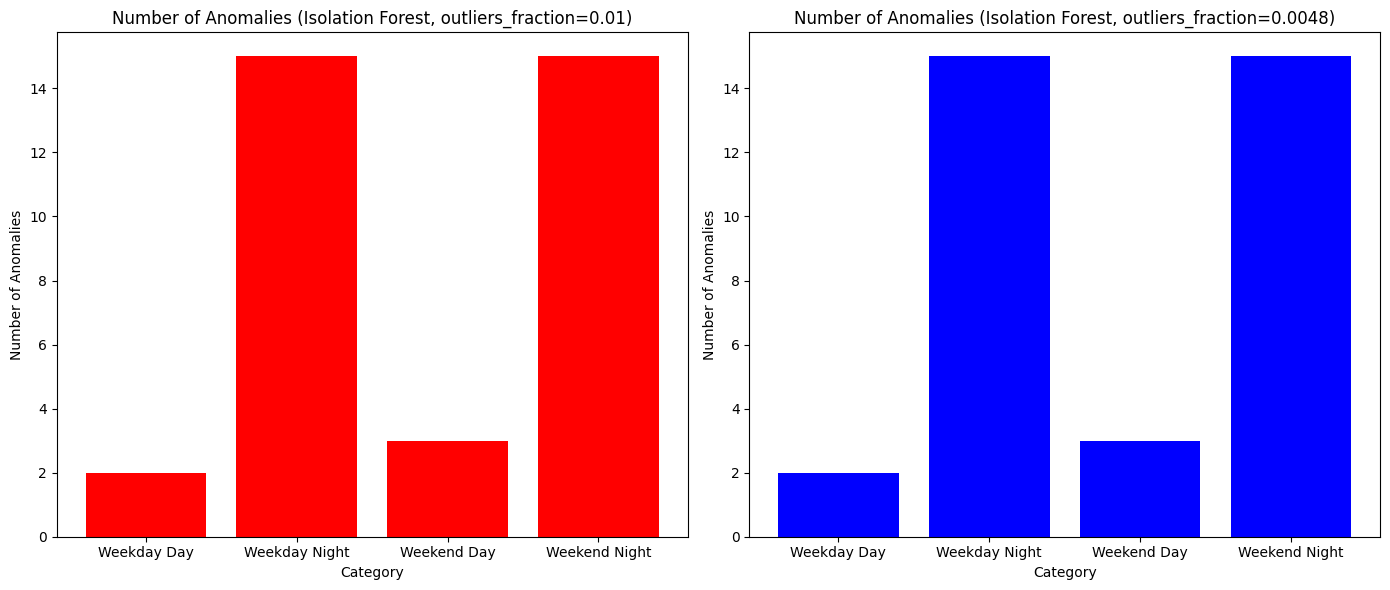

(           dtcat  Number of Anomalies
 0    Weekday Day                    2
 1  Weekday Night                   15
 2    Weekend Day                    3
 3  Weekend Night                   15,
            dtcat  Number of Anomalies
 0    Weekday Day                    2
 1  Weekday Night                   15
 2    Weekend Day                    3
 3  Weekend Night                   15)

In [ ]:
# Importing required library for IsolationForest
from sklearn.ensemble import IsolationForest

# Function to apply Isolation Forest and find anomalies
def apply_isolation_forest(X_scaled, outliers_fraction):
    model = IsolationForest(contamination=outliers_fraction, random_state=42)
    model.fit(X_scaled)
    df['anomaly_isolation_forest'] = model.predict(X_scaled)
    return df

# Applying Isolation Forest with outliers_fraction=0.01
df_anomalies_if_1 = apply_isolation_forest(X_scaled, outliers_fraction_1)

# Applying Isolation Forest with calculated outliers_fraction
df_anomalies_if_2 = apply_isolation_forest(X_scaled, outliers_fraction_2)

# Listing anomalies for both scenarios
anomalies_if_1 = list_anomalies(df_anomalies_if_1, column='anomaly_isolation_forest')
anomalies_if_2 = list_anomalies(df_anomalies_if_2, column='anomaly_isolation_forest')

# Visualizing the anomalies
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar(anomalies_if_1['dtcat'], anomalies_if_1['Number of Anomalies'], color='r')
plt.title('Number of Anomalies (Isolation Forest, outliers_fraction=0.01)')
plt.xlabel('Category')
plt.ylabel('Number of Anomalies')

plt.subplot(1, 2, 2)
plt.bar(anomalies_if_2['dtcat'], anomalies_if_2['Number of Anomalies'], color='b')
plt.title(f'Number of Anomalies (Isolation Forest, outliers_fraction={outliers_fraction_2:.4f})')
plt.xlabel('Category')
plt.ylabel('Number of Anomalies')

plt.tight_layout()
plt.show()

# Displaying the number of anomalies in each category
anomalies_if_1, anomalies_if_2

After fitting the model and labeling the data, I observed that the anomalies are distributed among three categories: 'Weekday Night', 'Weekend Day', and 'Weekend Night'. The majority of anomalies (30) are still clustered in the 'Weekend Night' category for both scenarios. This suggests that the device may be more prone to anomalies or failures during weekend nights.

# Comparing the Performance of Elliptic Envelope and Isolation Forest:

Here, I'll evaluate which of the two models: Elliptic Envelope or Isolation Forest performs better in detecting anomalies in the dataset. The evaluation will be based on: Coverage: How many categories are the anomalies spread across? More categories imply a more comprehensive anomaly detection. Concentration: Are the anomalies concentrated in specific categories? If the anomalies are concentrated in one or few categories, it might indicate periods where the device is more prone to fail. Consistency: How consistent are the anomalies between the two outliers_fraction scenarios? Consistency indicate robustness. Now, I will summarize the findings for each criterion:

#### Coverage:
Elliptic Envelope: Anomalies are found only in the 'Weekend Night' category.
Isolation Forest: Anomalies are found in 'Weekday Night', 'Weekend Day', and 'Weekend Night' categories.
#### Concentration:
Elliptic Envelope: All 35 anomalies are concentrated in the 'Weekend Night' category.
Isolation Forest: Majority of anomalies (30) are in the 'Weekend Night' category, but some are in 'Weekday Night' and 'Weekend Day'.
#### Consistency:
Elliptic Envelope: Consistently identified anomalies in the 'Weekend Night' category for both scenarios.
Isolation Forest: Consistently identified anomalies in the 'Weekend Night', 'Weekday Night', and 'Weekend Day' categories for both scenarios.

#### Conclusion:
The Isolation Forest algorithm provides broader coverage by identifying anomalies across multiple categories, thereby offering a more comprehensive view. It also shows consistency across different outliers_fraction scenarios. However, both models are consistent in highlighting 'Weekend Night' as a critical period for anomalies.